In [1]:
from pathlib import Path
from glob import glob
import numpy as np
import xarray as xr
import pandas as pd
import rioxarray as rxa
import matplotlib.pyplot as plt

from insitu import get_uavsar_insitu

from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = xr.open_dataset('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/232_2021-01-27_2021-02-03.sd.nc')

OSError: [Errno -101] NetCDF: HDF error: b'/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/232_2021-01-27_2021-02-03.sd.nc'

In [2]:
inc_232 = rxa.open_rasterio('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/images/lowman_23205_20002-007_20007-003_0013d_s01_L090_01_int_grd/lowman_23205_20007_003_200213_L090_CX_01.inc.tiff', mask_and_scale = True)
inc_052 = rxa.open_rasterio('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/images/lowman_05208_21009-005_21012-004_0007d_s01_L090_01_int_grd/lowman_05208_21012_004_210210_L090_CX_01.inc.tiff', mask_and_scale = True)

In [3]:
df = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/all_insitu.parq')

ncs_fp = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/')
a = []
for fp in ncs_fp.glob('*-*.nc'):

    # if '.insitu.' not in str(fp):

        img = xr.open_dataset(fp)
        df1, df2 = get_uavsar_insitu(df, img)

        diff = df2.set_index('site_name')[['SWE','SD']] - (df1.set_index('site_name')[['SWE','SD']])
        delta = diff.mean()
        den = pd.concat([df1, df2])['density'].mean()
        print(f"{img.attrs['time1']} to {img.attrs['time2']} SWE change is {delta['SWE']}. SD change is {delta['SD']}. Density is {den}")
        img.attrs['dSWE'] = delta['SWE']
        img.attrs['dSD'] = delta['SD']
        img.attrs['mean_density'] = den
        
        if fp.stem[:3] == '232':
            inc = inc_232.rio.reproject_match(img['cor'])
            img['inc'] = inc_232.rio.reproject_match(img['cor'])
        elif fp.stem[:3] == '052':
            inc = inc_052.rio.reproject_match(img['cor'])
        
        inc = inc.squeeze(dim = 'band')
        inc = inc.drop_vars('band')

        inc = inc.where(inc < 10000).where(inc > -10000)

        img['inc'] = inc

        mean_inc = img['inc'].mean()

        phase_theor = phase_from_depth(img.attrs['dSD'], mean_inc, density = den)

        for img_type in ['unw', 'int']:

            if img_type not in img.data_vars:

                continue
        
            img[f'sd_delta_{img_type}'] = xr.zeros_like(img[img_type])

            for band in ['VV', 'VH', 'HV', 'HH']:

                mean_phase = img[img_type].sel(band = band).mean()

                img[img_type].loc[dict(band = band)] = img[img_type].sel(band = band) + (phase_theor - mean_phase)

                img[f'sd_delta_{img_type}'].loc[dict(band = band)] = depth_from_phase(img[img_type].sel(band = 'VV'), img['inc'], density = img.attrs['mean_density'])

        img1 = img

2021-01-27 to 2021-02-03 SWE change is 0.04926285714285715. SD change is 0.25034285714285714. Density is 278.6666666666667
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided

KeyboardInterrupt: 

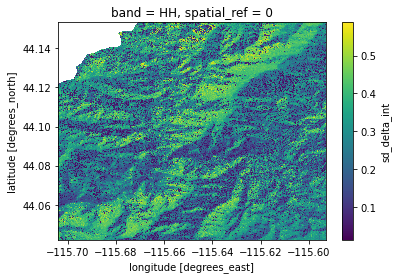

In [13]:
img1['sd_delta_int'].sel(band = 'HH')[6000:8000, 12000: 14000].plot()

In [ ]:
img.to_netcdf

In [14]:
fp.with_suffix('.proc.nc')

PosixPath('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/232_2021-03-16_2021-03-22.proc.nc')

In [3]:
ds = xr.open_dataset('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/232_2021-01-27_2021-02-03.sd.nc')

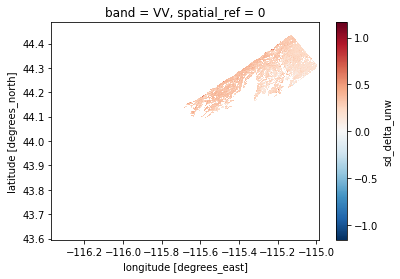

In [22]:
ds['sd_delta_unw'].sel(band = 'VV').plot()

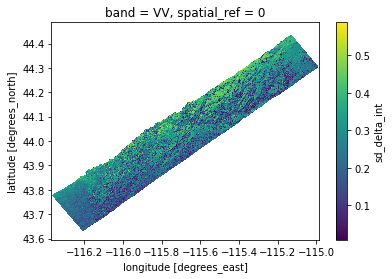

In [23]:
ds['sd_delta_int'].sel(band = 'VV').plot()

In [68]:
df = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/all_insitu.parq')
df1, df2 = get_uavsar_insitu(df, ds)

In [71]:
1.5748 - 1.1938

0.381

In [72]:
snotel_x = -115.23447
snotel_y = 44.30342
tol = 0.001 # 0.001 degrees or ~100m
ds.sel(y = slice(snotel_y + tol, snotel_y - tol)).sel(x = slice(snotel_x - tol, snotel_x + tol)).sel(band = 'VV')['sd_delta_int'].mean()

<xarray.DataArray 'sd_delta_int' ()>
array(0.32521582, dtype=float32)
Coordinates:
    band         <U2 'VV'
    spatial_ref  int64 0

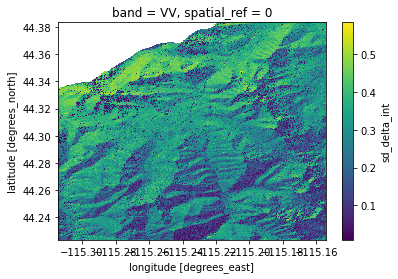

In [77]:
snotel_x = -115.23447
snotel_y = 44.30342
tol = 0.08 # 0.001 degrees or ~100m
ds.sel(y = slice(snotel_y + tol, snotel_y - tol)).sel(x = slice(snotel_x - tol, snotel_x + tol)).sel(band = 'VV')['sd_delta_int'].plot()